# CBC Grammar Correction Model - DUAL TASK Mistral 7B Fine-tuning

## Project Overview
This notebook implements fine-tuning of Mistral 7B Instruct model for CBC-aligned grammar correction and educational feedback generation. The model is trained on curated grammar correction data with structured feedback following Rwandan CBC guidelines.

## Notebook Structure
1. **Environment Setup** - Package installation and imports
2. **Data Preparation** - File upload and authentication
3. **Data Engineering Considerations** - Project-specific rationale
4. **Data Visualization** - Dataset analysis and characteristics
5. **Model Configuration** - Mistral 7B setup with quantization and LoRA
6. **Data Processing** - Tokenization and dataset preparation
7. **Training Configuration** - Hyperparameters and training setup
8. **Model Training** - Fine-tuning execution
9. **Model Evaluation** - Testing and performance assessment
10. **Model Saving** - Export trained model for deployment


## Section 1: Environment Setup

### Package Installation
Install required packages for Mistral 7B fine-tuning with quantization and LoRA support.

In [18]:
# Install required packages for Mistral 7B fine-tuning
!pip install transformers datasets accelerate bitsandbytes torch
!pip install peft trl
!pip install sacrebleu rouge-score
!pip install --upgrade evaluate
!pip install rouge_score

### Library Imports
Import all required libraries for model training, data processing, and evaluation.

In [19]:
# Import required libraries for Mistral 7B training
from collections import Counter
from datasets import Dataset, DatasetDict
from google.colab import files
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from peft import LoraConfig, get_peft_model, TaskType
from rouge_score import rouge_scorer
from sacrebleu import BLEU
import seaborn as sns
import torch
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TrainingArguments, Trainer,
    BitsAndBytesConfig
)

## Section 2: Data Preparation

### Dataset Upload
Upload the CBC grammar correction dataset in JSONL format for training.

In [20]:
# Upload CBC grammar correction dataset
uploaded = files.upload()
jsonl_file = list(uploaded.keys())[0]


Saving cbc_dataset.jsonl to cbc_dataset (3).jsonl


### Hugging Face Authentication
Authenticate with Hugging Face to access Mistral 7B model and configure quantization for memory efficiency.

In [ ]:
# Authenticate with Hugging Face and setup quantization
from huggingface_hub import login

# Hugging Face authentication token
hf_token = "your hugging face token"
login(token=hf_token)

# Configure 4-bit quantization for memory efficiency
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)


## Section 3: Data Engineering Considerations

### Why Traditional Data Engineering is Not Applicable

This CBC Grammar Correction project operates on a pre-processed, structured dataset that has already undergone the necessary data engineering phases. The following traditional data engineering components are not required:

- **Data Cleaning**: The dataset is derived from curated WI+LOCNESS grammar correction data with manually verified CBC-aligned feedback, eliminating the need for automated cleaning processes.

- **Data Transformation**: The CSV-to-JSONL conversion pipeline has been completed, and the data structure is optimized for transformer model training without requiring additional transformations.

- **Data Quality Validation**: The dataset consists of high-quality, manually reviewed grammar corrections with educational feedback, making automated quality checks redundant.

- **Data Pipeline Architecture**: The project uses direct data loading into the training pipeline, eliminating the need for complex ETL processes or data orchestration systems.

- **Real-time Data Processing**: This is a static training dataset for model fine-tuning, not a dynamic system requiring real-time data processing capabilities.

The focus of this project is on **data visualization and analysis** to understand dataset characteristics and **model training optimization** rather than data engineering infrastructure. The dataset's quality and structure make it immediately suitable for machine learning model training without additional preprocessing requirements.


## Section 4: Data Visualization and Analysis

### Dataset Characteristics Analysis
Comprehensive visualization of the CBC grammar correction dataset to understand data distributions, correlations, and training readiness.

In [22]:
def analyze_dataset_for_visualization(filename):
    data = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                item = json.loads(line)
                output = item['output']

                if 'CORRECTION:' in output and 'FEEDBACK:' in output:
                    correction = output.split('CORRECTION:')[1].split('FEEDBACK:')[0].strip()
                    feedback = output.split('FEEDBACK:')[1].strip()
                else:
                    correction = output
                    feedback = ""

                data.append({
                    'input': item['input'],
                    'correction': correction,
                    'feedback': feedback,
                    'input_length': len(item['input'].split()),
                    'correction_length': len(correction.split()),
                    'feedback_length': len(feedback.split()),
                    'input_chars': len(item['input']),
                    'correction_chars': len(correction),
                    'feedback_chars': len(feedback)
                })
    return pd.DataFrame(data)

df = analyze_dataset_for_visualization(jsonl_file)

# summary of distribution plots
# summary of distribution plots
From the histogram plots of the **input**, **correction**, **feedback**, and **output (correction + feedback)**. It was observed in this research that the input and correction texts i.e. **synthetically generated and augmented** have nearly identical average lengths (15.8 vs 15.5 words), which is actually very positive for the grammar correction task. This similarity indicates that the augmented dataset contains mostly localized grammar corrections rather than major structural rewrites, suggesting the research model will learn to make precise, targeted fixes rather than completely restructuring sentences - exactly what is intended for the research grammar correction tool. The feedback length averaging 37.1 words is excellent for educational purposes, being roughly double the length of input/correction texts, which indicates the synthetical generated CBC-aligned feedback based on [https://www.nesa.gov.rw/index.php?eID=dumpFile&t=f&f=21444&token=c3cbfcc74583f0842d78d139c38e3da4b70273b7] is comprehensive and provides meaningful explanations while remaining digestible for Teachers.

/tmp/ipython-input-2425548526.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(length_data, labels=['Input', 'Correction', 'Feedback'])
/tmp/ipython-input-2425548526.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(char_data, labels=['Input', 'Correction', 'Feedback'])


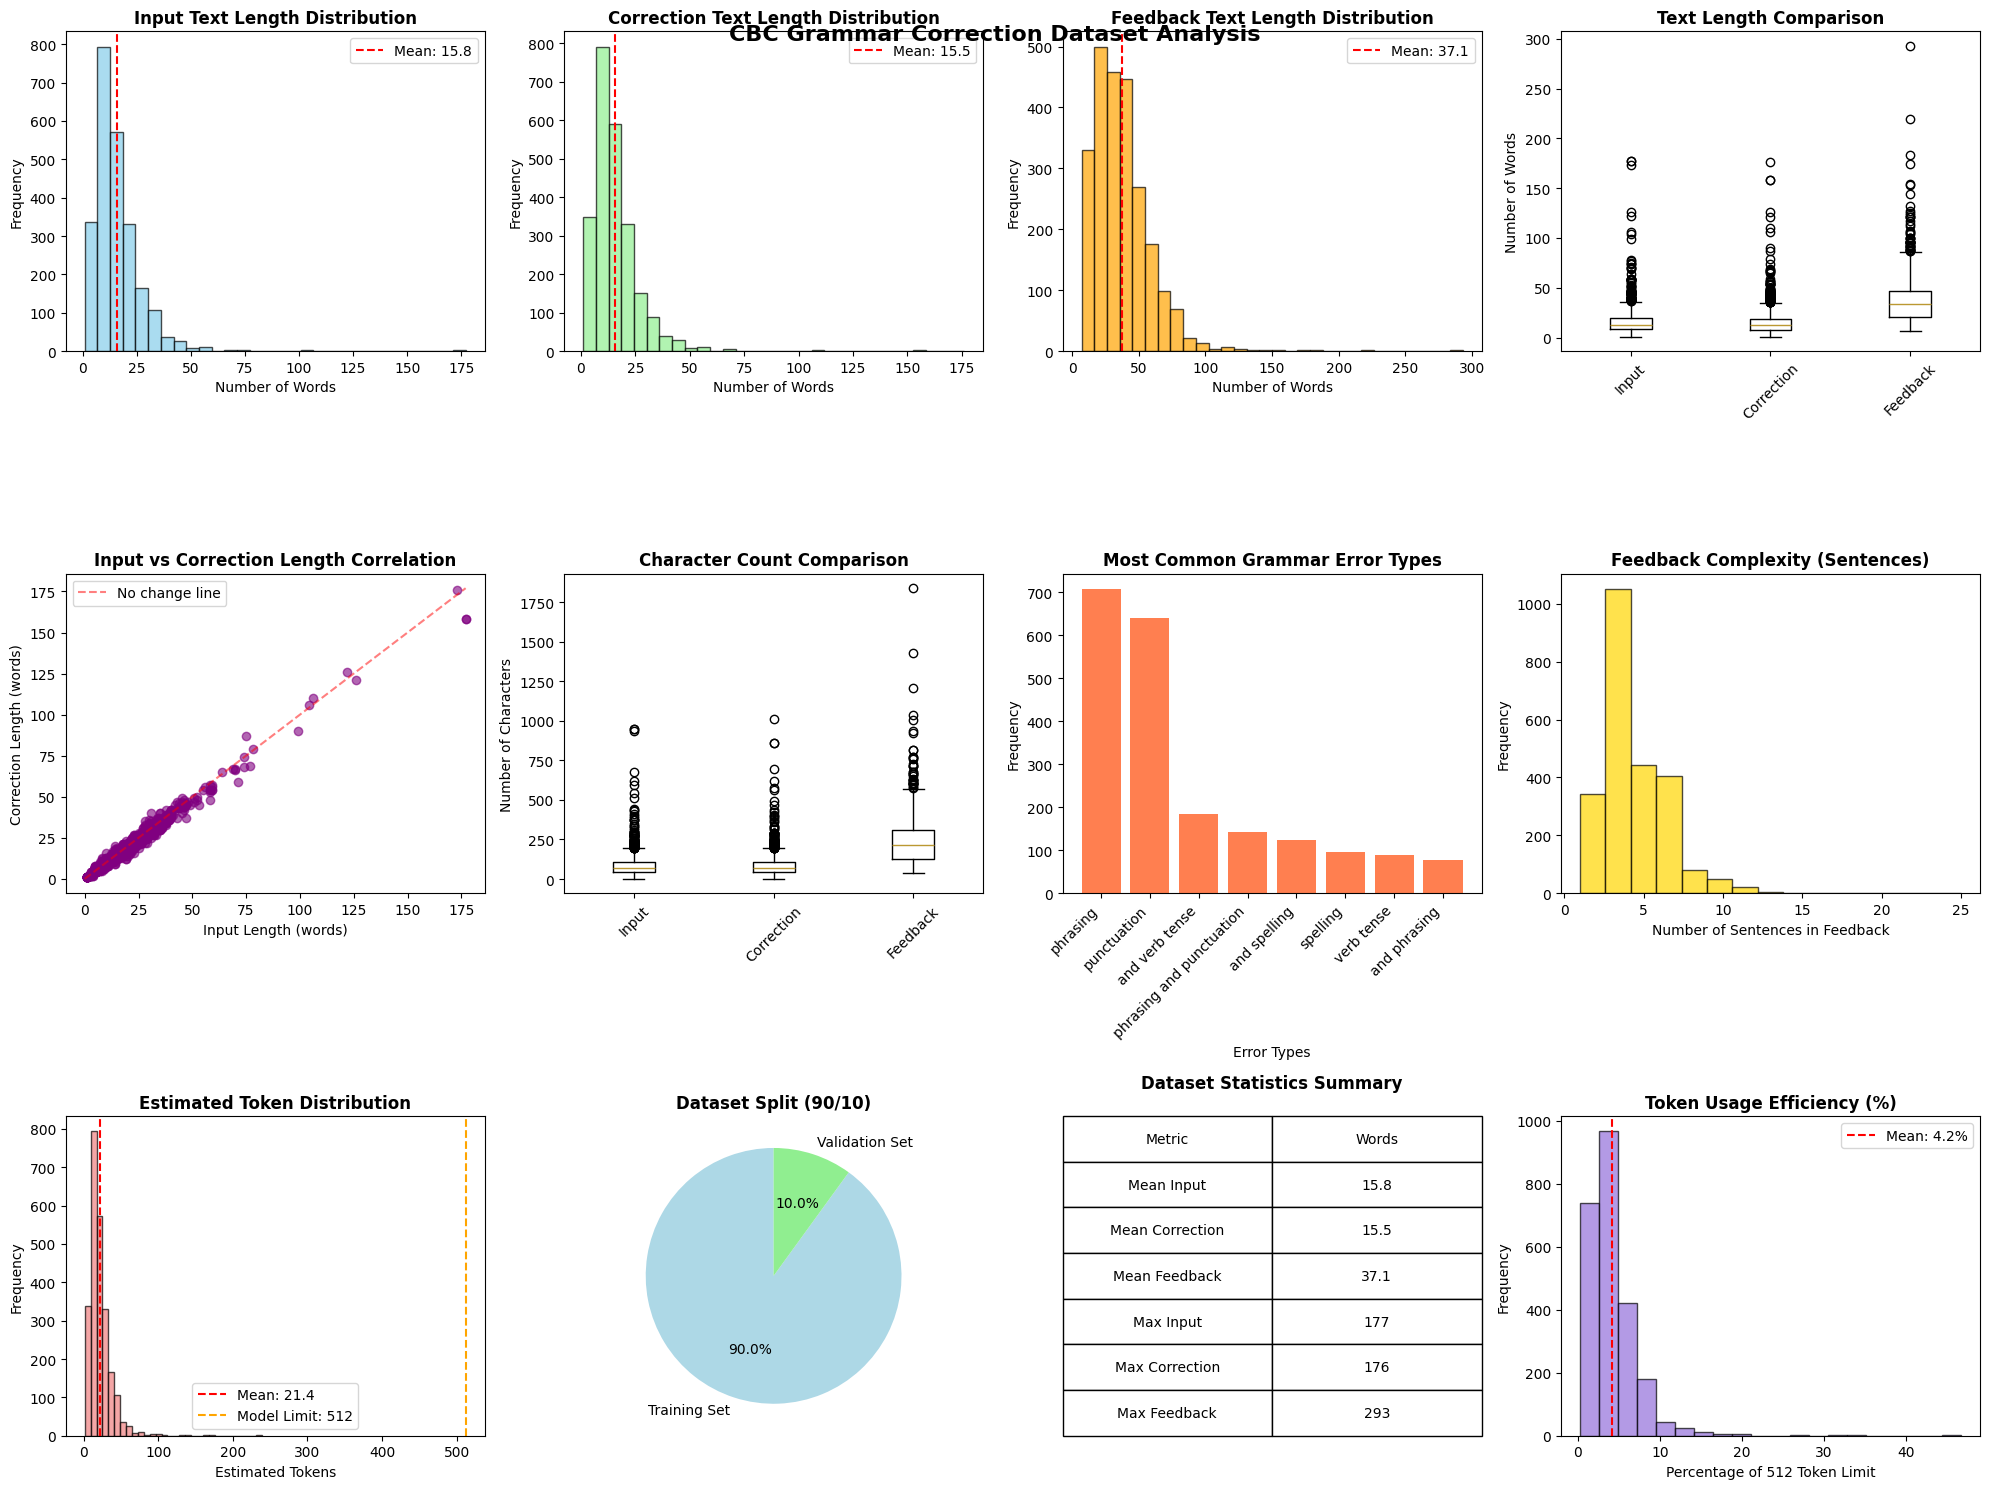

Dataset Analysis Complete: 2402 samples, 15.8 avg input words, 21.4 avg tokens


In [23]:
plt.style.use('default')
sns.set_palette("husl")
fig = plt.figure(figsize=(20, 15))

# Text Length Distributions
plt.subplot(3, 4, 1)
plt.hist(df['input_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Input Text Length Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(df['input_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["input_length"].mean():.1f}')
plt.legend()

plt.subplot(3, 4, 2)
plt.hist(df['correction_length'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Correction Text Length Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(df['correction_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["correction_length"].mean():.1f}')
plt.legend()

plt.subplot(3, 4, 3)
plt.hist(df['feedback_length'], bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Feedback Text Length Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(df['feedback_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["feedback_length"].mean():.1f}')
plt.legend()

# Length Comparisons
plt.subplot(3, 4, 4)
length_data = [df['input_length'], df['correction_length'], df['feedback_length']]
plt.boxplot(length_data, labels=['Input', 'Correction', 'Feedback'])
plt.title('Text Length Comparison', fontsize=12, fontweight='bold')
plt.ylabel('Number of Words')
plt.xticks(rotation=45)

# Input vs Correction Length Correlation
plt.subplot(3, 4, 5)
plt.scatter(df['input_length'], df['correction_length'], alpha=0.6, color='purple')
plt.xlabel('Input Length (words)')
plt.ylabel('Correction Length (words)')
plt.title('Input vs Correction Length Correlation', fontsize=12, fontweight='bold')
max_len = max(df['input_length'].max(), df['correction_length'].max())
plt.plot([0, max_len], [0, max_len], 'r--', alpha=0.5, label='No change line')
plt.legend()

# Character Count Analysis
plt.subplot(3, 4, 6)
char_data = [df['input_chars'], df['correction_chars'], df['feedback_chars']]
plt.boxplot(char_data, labels=['Input', 'Correction', 'Feedback'])
plt.title('Character Count Comparison', fontsize=12, fontweight='bold')
plt.ylabel('Number of Characters')
plt.xticks(rotation=45)

# Grammar Error Type Analysis
plt.subplot(3, 4, 7)
error_types = []
for feedback in df['feedback']:
    if feedback and 'The error is' in feedback:
        error_part = feedback.split('The error is')[1].split('.')[0].strip()
        error_types.extend([e.strip() for e in error_part.split(',')])

error_counter = Counter(error_types)
top_errors = dict(error_counter.most_common(8))

if top_errors:
    plt.bar(range(len(top_errors)), list(top_errors.values()), color='coral')
    plt.title('Most Common Grammar Error Types', fontsize=12, fontweight='bold')
    plt.xlabel('Error Types')
    plt.ylabel('Frequency')
    plt.xticks(range(len(top_errors)), list(top_errors.keys()), rotation=45, ha='right')

# Feedback Complexity Analysis
plt.subplot(3, 4, 8)
feedback_sentences = df['feedback'].str.count('\\.')
plt.hist(feedback_sentences, bins=15, alpha=0.7, color='gold', edgecolor='black')
plt.title('Feedback Complexity (Sentences)', fontsize=12, fontweight='bold')
plt.xlabel('Number of Sentences in Feedback')
plt.ylabel('Frequency')

# Token Distribution Analysis
plt.subplot(3, 4, 9)
estimated_tokens = df['input_length'] * 1.35
plt.hist(estimated_tokens, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Estimated Token Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Estimated Tokens')
plt.ylabel('Frequency')
plt.axvline(estimated_tokens.mean(), color='red', linestyle='--', label=f'Mean: {estimated_tokens.mean():.1f}')
plt.axvline(512, color='orange', linestyle='--', label='Model Limit: 512')
plt.legend()

# Dataset Split Visualization
plt.subplot(3, 4, 10)
total_samples = len(df)
val_samples = int(total_samples * 0.1)
train_samples = total_samples - val_samples
sizes = [train_samples, val_samples]
labels = ['Training Set', 'Validation Set']
colors = ['lightblue', 'lightgreen']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Dataset Split (90/10)', fontsize=12, fontweight='bold')

# Statistical Summary
plt.subplot(3, 4, 11)
stats_data = [
    ['Mean Input', f"{df['input_length'].mean():.1f}"],
    ['Mean Correction', f"{df['correction_length'].mean():.1f}"],
    ['Mean Feedback', f"{df['feedback_length'].mean():.1f}"],
    ['Max Input', f"{df['input_length'].max()}"],
    ['Max Correction', f"{df['correction_length'].max()}"],
    ['Max Feedback', f"{df['feedback_length'].max()}"]
]
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=stats_data,
                 colLabels=['Metric', 'Words'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title('Dataset Statistics Summary', fontsize=12, fontweight='bold', pad=20)

# Token Usage Efficiency
plt.subplot(3, 4, 12)
token_usage = (estimated_tokens / 512 * 100).clip(0, 100)
plt.hist(token_usage, bins=20, alpha=0.7, color='mediumpurple', edgecolor='black')
plt.title('Token Usage Efficiency (%)', fontsize=12, fontweight='bold')
plt.xlabel('Percentage of 512 Token Limit')
plt.ylabel('Frequency')
plt.axvline(token_usage.mean(), color='red', linestyle='--', label=f'Mean: {token_usage.mean():.1f}%')
plt.legend()

plt.tight_layout()
plt.suptitle('CBC Grammar Correction Dataset Analysis', fontsize=16, fontweight='bold', y=0.98)
plt.show()

print(f"Dataset Analysis Complete: {len(df)} samples, {df['input_length'].mean():.1f} avg input words, {estimated_tokens.mean():.1f} avg tokens")

In [24]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter


## Section 5: Model Configuration

### Mistral 7B Instruct Model Setup
Load and configure the Mistral 7B Instruct model with 4-bit quantization for memory efficiency and LoRA for efficient fine-tuning.

## Model Architecture

### Base Architecture: Mistral 7B Instruct V1 Transformer

The foundation of this CBC Grammar Correction system is built upon the Mistral 7B transformer architecture **Figure 4**, which represents an advanced evolution of the standard transformer framework. The Mistral 7B model employs a sophisticated transformer based architecture that incorporates several innovative modifications compared to traditional implementations such as Llama. The architecture utilizes a sliding window attention **Figure 1** mechanism that enables each hidden state at position i in layer k to attend to all hidden states from the previous layer within a specified window range of i-W to i positions. This recursive attention pattern allows the model to access tokens from the input layer at distances up to W × k tokens, effectively creating an exponentially expanding attention span. When configured with a window size of W = 4096, the final layer achieves a theoretical attention span of approximately 131,000 tokens, demonstrating significant scalability advantages over conventional attention mechanisms. The implementation incorporates optimized versions of FlashAttention and xFormers techniques, resulting in a 2x speed improvement over standard attention baselines for sequences of 16K tokens.

Additionally, the architecture implements a rolling buffer cache system **Figure 2** that maintains a fixed cache size of W positions, where keys and values for timestep i are stored at position i mod W, enabling efficient memory management by overwriting past values when the position exceeds the window size. This approach reduces cache memory usage by 8x for 32K token sequences without compromising model quality. The system also employs pre-fill and chunking **Figure 3** strategies for sequence generation, allowing the model to pre-compute attention over known prompts and process large inputs in manageable chunks corresponding to the window size  (Jiang et al., 2023).

**Figure 1: SLIDING WINDOW ATTENTION**

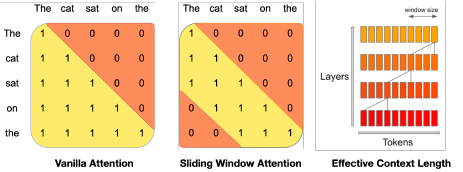

**Figure 2: Rolling Buffer Cache**

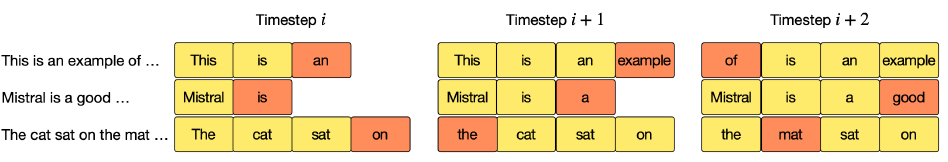

**Figure 3: Pre-Fill and Chunking**

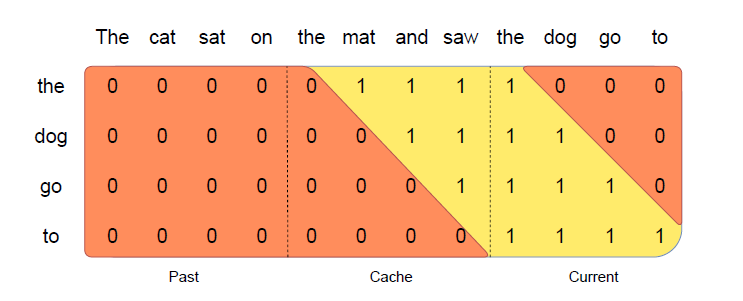



**Figure 4: Model Architecture**

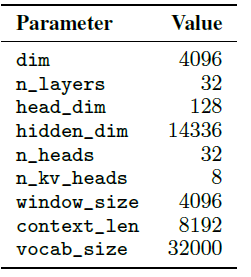

### Fine-tuned Architecture Configuration and Implementation

The fine-tuned model, designated as mistral-grammar-fine-tuned_dual_task, is built upon the AutoModelForCausalLM framework (Hugging Face, 2018) using the pre-trained mistralai/Mistral-7B-Instruct-v0.1 model (Jiang et al., 2023) as its foundation. The fine-tuning process employs LoRA (Low-Rank Adaptation) methodology combined with 4-bit quantization to achieve efficient adaptation while maintaining computational efficiency. The training configuration utilizes a learning rate of 5.00E-05 (5 × 10⁻⁵), which provides optimal convergence for the dual-task learning approach. The optimization process is handled by the AdamW optimizer (Hugging Face, 2018), which is particularly effective for transformer-based models due to its adaptive learning rate capabilities and weight decay regularization. The loss function employed is CrossEntropyLoss (Hugging Face, 2022), which is standard for causal language modeling tasks and provides stable gradient computation during training. The training strategy implements dual-task learning to enable simultaneous grammar correction and CBC-aligned feedback generation, allowing the model to perform both tasks within a unified framework. The quantization approach utilizes 4-bit BitsAndBytesConfig for memory efficiency, significantly reducing computational requirements while preserving model performance. The LoRA configuration is set with **rank=16**, **alpha=32**, **dropout=0.1**, and specifically targets attention and MLP layers to maximize adaptation efficiency while minimizing parameter overhead.

### Architecture Modifications for CBC Grammar Correction

The fine-tuned model extends the base Mistral 7B architecture through several specialized adaptations designed specifically for CBC grammar correction tasks. The dual-task training approach enables the model to simultaneously perform grammar correction and generate educational feedback aligned with Rwandan CBC guidelines, creating a comprehensive language learning tool. The LoRA (Low-Rank Adaptation) technique allows efficient fine-tuning by adapting only a small subset of parameters while maintaining the full model's knowledge base, enabling rapid deployment without extensive computational resources. The 4-bit quantization reduces memory requirements by approximately 75% while preserving model performance, enabling training on consumer-grade hardware and facilitating broader accessibility. The model processes input text through the standard Mistral transformer layers, applies learned corrections through the dual-task head architecture, and generates structured output containing both corrected text and educational feedback explanations. This integrated approach ensures that grammar corrections and educational feedback are contextually aligned, providing students with comprehensive learning support that follows CBC pedagogical principles while maintaining the sophisticated language understanding capabilities of the base Mistral 7B model.

**Figure 4: DUAL TASK CBC GRAMMAR AND FEEDBACK FINE TUNED ARCHITECTURE**
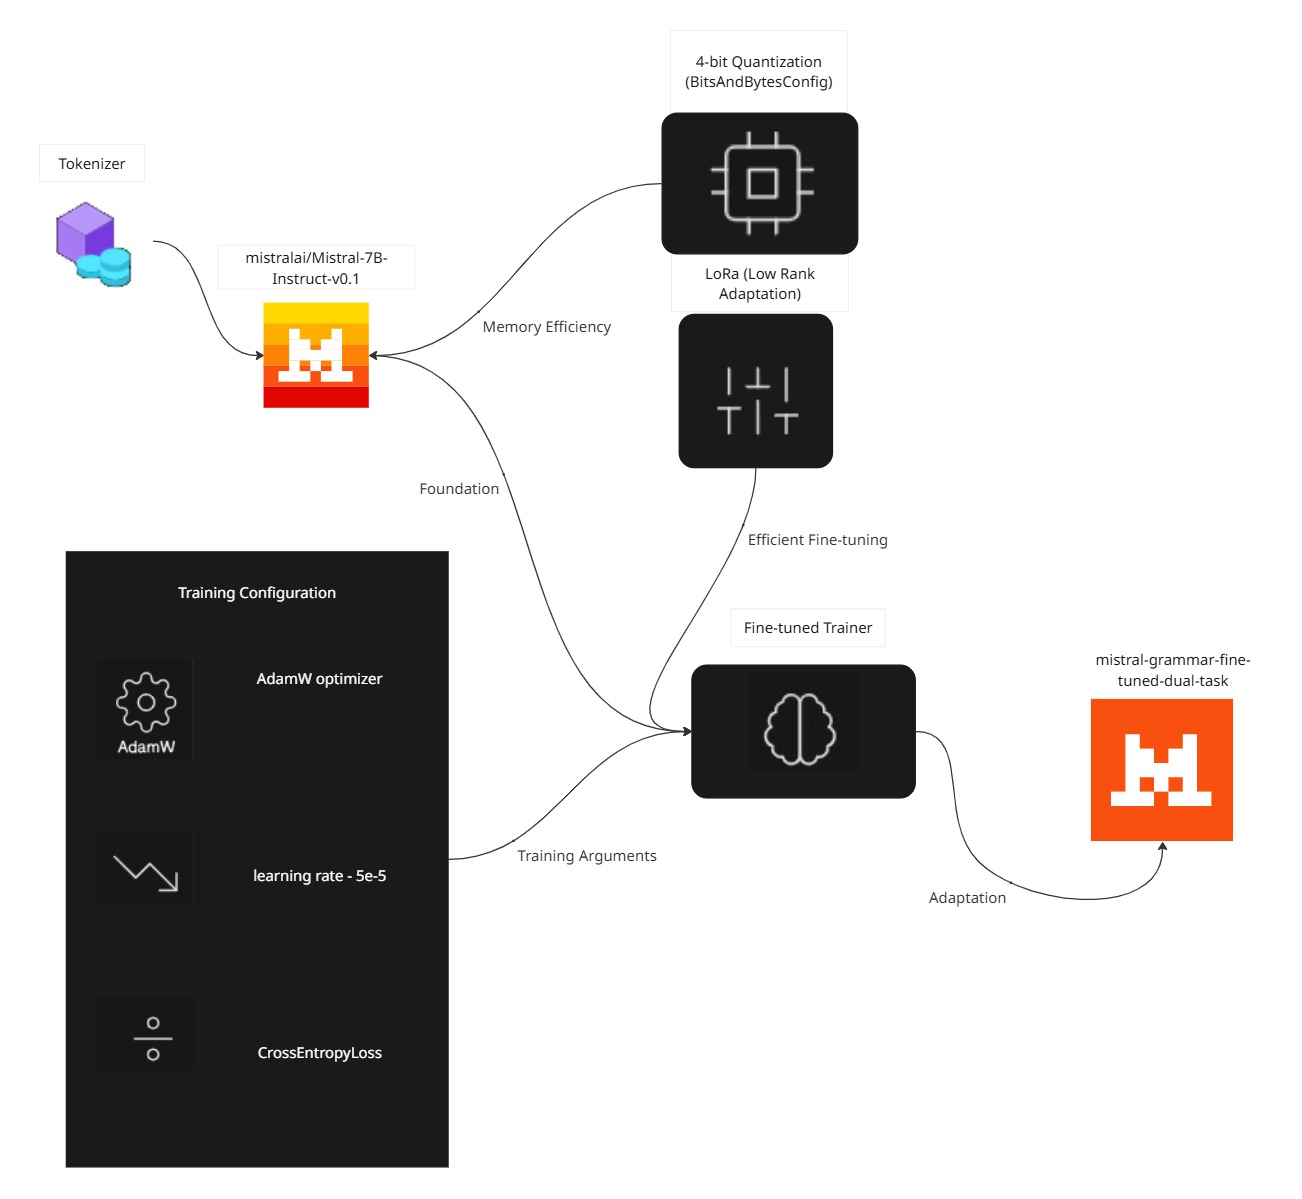

In [25]:
# Load Mistral 7B Instruct (the correct version!)
model_name = "mistralai/Mistral-7B-Instruct-v0.1"

print("Loading Mistral 7B Instruct tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print("Loading Mistral 7B Instruct model with quantization...")
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map="auto",
    trust_remote_code=True
)

print(f"Model loaded: {model_name}")
print(f"Model parameters: {model.num_parameters():,}")
print(f"Tokenizer vocab size: {tokenizer.vocab_size:,}")
print(f"Model device: {next(model.parameters()).device}")


Loading Mistral 7B Instruct tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Loading Mistral 7B Instruct model with quantization...


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Model loaded: mistralai/Mistral-7B-Instruct-v0.1
Model parameters: 7,241,732,096
Tokenizer vocab size: 32,000
Model device: cuda:0


In [26]:
# Setup LoRA for efficient fine-tuning
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

print("Applying LoRA configuration...")
model = get_peft_model(model, lora_config)
print("LoRA applied successfully!")

# Count trainable parameters properly
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Trainable %: {100 * trainable_params / total_params:.2f}%")


Applying LoRA configuration...
LoRA applied successfully!
Total parameters: 3,794,014,208
Trainable parameters: 41,943,040
Trainable %: 1.11%


## Section 6: Data Processing

### Dataset Preparation and Tokenization
Load the CBC grammar correction dataset, prepare dual-task training data, and tokenize for Mistral 7B training with proper label masking.

In [27]:
# Load and prepare data for Mistral 7B Instruct
def load_data_mistral_dual_task(filename):
    correction_data = []
    feedback_data = []

    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                item = json.loads(line)

                # Parse the output to extract correction and feedback
                output = item['output']
                if 'CORRECTION:' in output and 'FEEDBACK:' in output:
                    correction = output.split('CORRECTION:')[1].split('FEEDBACK:')[0].strip()
                    feedback = output.split('FEEDBACK:')[1].strip()

                    # TASK 1: CORRECTION TASK - Mistral instruction format
                    correction_prompt = f"<s>[INST] Correct the grammar errors in this sentence: {item['input']} [/INST]"
                    correction_data.append({
                        'text': correction_prompt,
                        'target': correction
                    })

                    # TASK 2: FEEDBACK TASK - Mistral instruction format
                    feedback_prompt = f"<s>[INST] Identify the specific grammar errors in this sentence and explain the correct grammar rules: {item['input']} [/INST]"
                    feedback_data.append({
                        'text': feedback_prompt,
                        'target': feedback
                    })
                else:
                    # Fallback for malformed data
                    correction_prompt = f"<s>[INST] Correct the grammar in this sentence: {item['input']} [/INST]"
                    correction_data.append({
                        'text': correction_prompt,
                        'target': output
                    })

                    feedback_prompt = f"<s>[INST] Identify grammar errors in this sentence and explain the correct grammar rules: {item['input']} [/INST]"
                    feedback_data.append({
                        'text': feedback_prompt,
                        'target': "Please check the sentence for grammar errors."
                    })

    return correction_data, feedback_data

# Load data
correction_data, feedback_data = load_data_mistral_dual_task(jsonl_file)

print(f"=== MISTRAL 7B INSTRUCT DUAL TASK DATA LOADING ===")
print(f"Correction task samples: {len(correction_data)}")
print(f"Feedback task samples: {len(feedback_data)}")
print(f"Total samples: {len(correction_data) + len(feedback_data)}")

# Combine both tasks for training
combined_data = correction_data + feedback_data
print(f"Combined training data: {len(combined_data)} samples")

# Create train/validation split
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(combined_data, test_size=0.1, random_state=42)

dataset = DatasetDict({
    'train': Dataset.from_list(train_data),
    'validation': Dataset.from_list(val_data)
})

print(f"Train: {len(dataset['train'])}, Validation: {len(dataset['validation'])}")


=== MISTRAL 7B INSTRUCT DUAL TASK DATA LOADING ===
Correction task samples: 2402
Feedback task samples: 2402
Total samples: 4804
Combined training data: 4804 samples
Train: 4323, Validation: 481


In [52]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'target'],
        num_rows: 4323
    })
    validation: Dataset({
        features: ['text', 'target'],
        num_rows: 481
    })
})

In [28]:
# Mistral tokenization for causal LM with proper masking
def preprocess_function(examples):
    inputs = examples['text']
    targets = examples['target']

    # Combine input and target for causal LM training
    texts = []
    for input_text, target_text in zip(inputs, targets):
        full_text = input_text + " " + target_text + tokenizer.eos_token
        texts.append(full_text)

    # Tokenize the full text
    model_inputs = tokenizer(
        texts,
        max_length=512,
        truncation=True,
        padding=False,
        return_tensors=None
    )

    # Tokenize just the input part to know where to start masking
    input_only = tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding=False,
        return_tensors=None
    )

    # Create labels with proper masking
    labels = []
    for i, (full_ids, input_ids) in enumerate(zip(model_inputs["input_ids"], input_only["input_ids"])):
        # Create labels array
        label = [-100] * len(full_ids)

        # Find where the target starts (after the input)
        input_len = len(input_ids)

        # Only compute loss on the target part (after input)
        # Use actual token ID for target part
        for j in range(input_len, len(full_ids)):
            if j < len(full_ids):
                label[j] = full_ids[j]

        labels.append(label)

    model_inputs["labels"] = labels
    return model_inputs

# Tokenize dataset with proper masking
print("Tokenizing dataset with proper label masking...")
tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)
print("Dataset tokenized successfully!")

# Check a sample
sample = tokenized_dataset['train'][0]
print(f"Sample input length: {len(sample['input_ids'])}")
print(f"Sample labels length: {len(sample['labels'])}")

# Verify masking is working
num_ignored = sum(1 for label in sample['labels'] if label == -100)
num_target = len(sample['labels']) - num_ignored
print(f"Masked tokens (ignored): {num_ignored}")
print(f"Target tokens (trained): {num_target}")
print(f"Sample labels: {sample['labels'][:20]}...")


Tokenizing dataset with proper label masking...


Map:   0%|          | 0/4323 [00:00<?, ? examples/s]

Map:   0%|          | 0/481 [00:00<?, ? examples/s]

Dataset tokenized successfully!
Sample input length: 82
Sample labels length: 82
Masked tokens (ignored): 47
Target tokens (trained): 35
Sample labels: [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]...


In [53]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4323
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 481
    })
})

## Section 7: Training Configuration

### Hyperparameters and Training Setup
Configure training arguments, initialize trainer, and setup validation metrics for Mistral 7B fine-tuning.

In [29]:
# Training arguments - Fixed to prevent overfitting
training_args = TrainingArguments(
    output_dir="./mistral-grammar-model",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    learning_rate=2e-5,
    save_strategy="no",
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=50,
    remove_unused_columns=False,
    warmup_steps=100,
    weight_decay=0.01,
    max_grad_norm=1.0,
    fp16=False,
    dataloader_pin_memory=False,
    report_to=None,
)

print("Mistral training arguments set!")
print(f"Training for {training_args.num_train_epochs} epochs")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"LoRA fine-tuning enabled")

Mistral training arguments set!
Training for 1 epochs
Effective batch size: 1
Learning rate: 2e-05
LoRA fine-tuning enabled


In [30]:
# Trainer with validation, with no data collator to avoid tensor issues
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
)

print("Mistral trainer initialized successfully!")
print(f"Model ready for LoRA fine-tuning")

Mistral trainer initialized successfully!
Model ready for LoRA fine-tuning


/tmp/ipython-input-2816568791.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Section 8: Model Training

### Fine-tuning Execution
Execute the Mistral 7B fine-tuning process with LoRA adaptation for CBC grammar correction and feedback generation.

In [32]:
# Start training
print("Starting Mistral 7B LoRA fine-tuning...")
# model.train()
trainer.train()
print("Training completed!")

Starting Mistral 7B LoRA fine-tuning...


Step,Training Loss,Validation Loss
50,1.795800,1.166560
100,0.588400,0.626474
150,0.602600,0.543552
200,0.651800,0.533152
250,0.500500,0.518390
300,0.319000,0.493170
350,0.669800,0.478710
400,0.565200,0.480099
450,0.669300,0.481339
500,0.635000,0.485156


Training completed!


**Figure 6: Train loss**
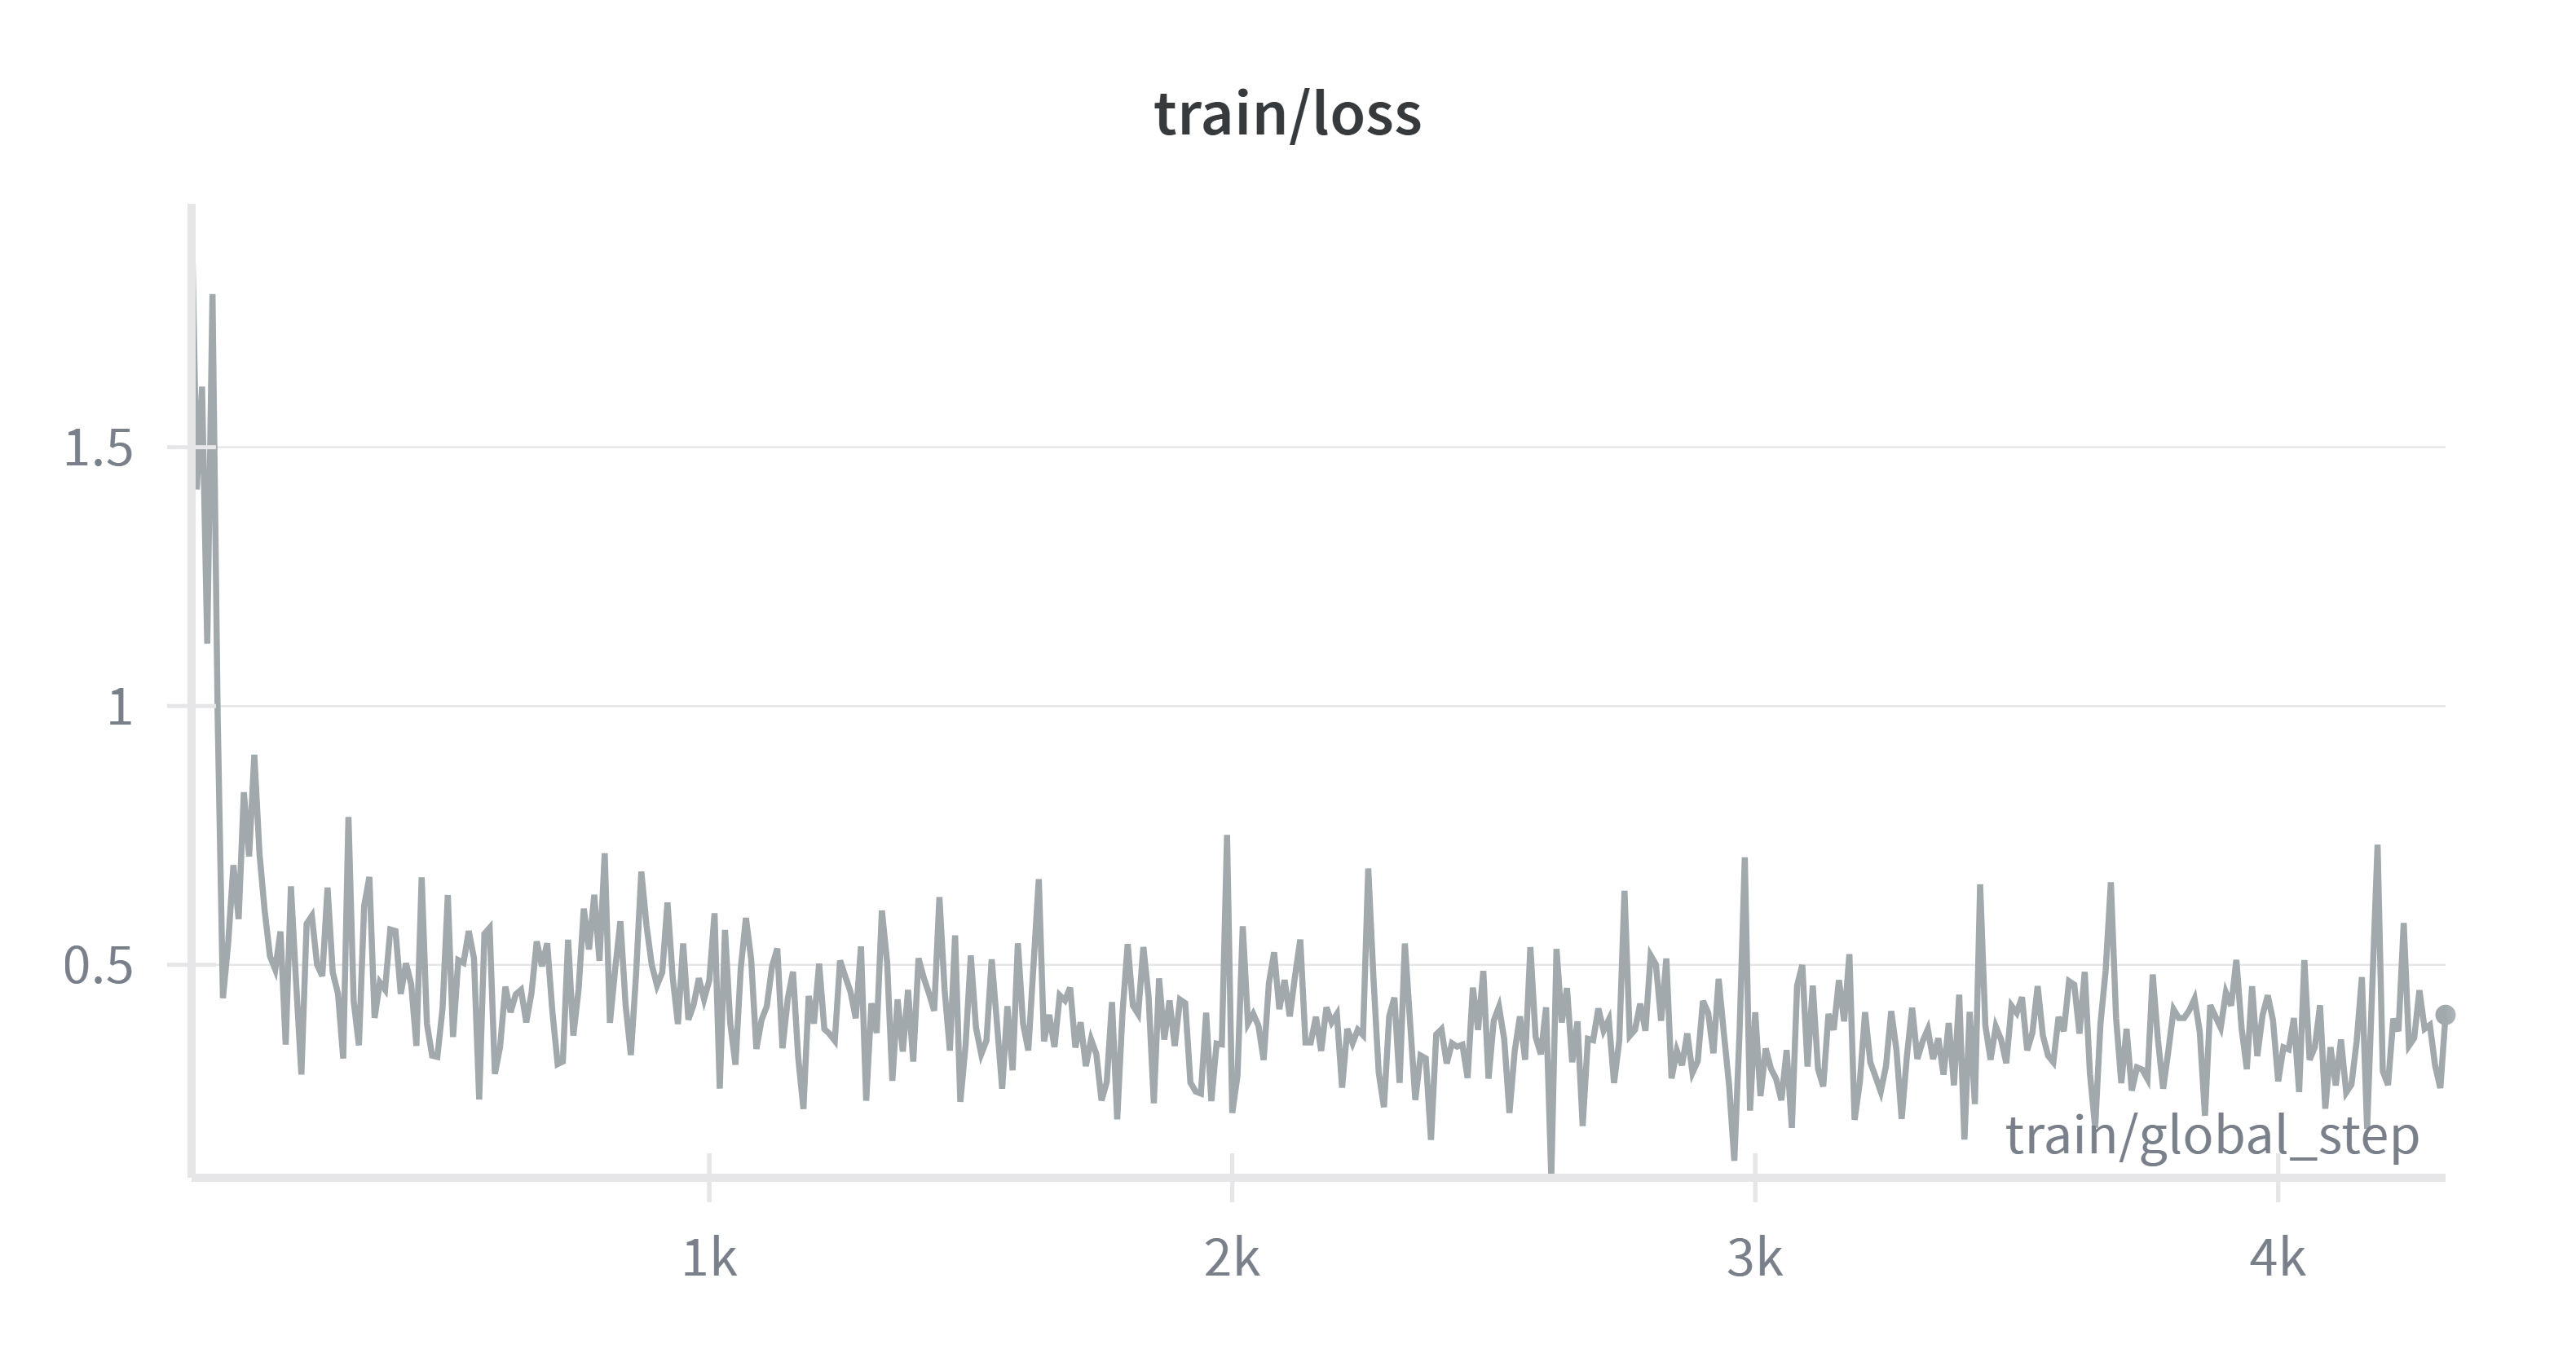

**Figure 7: Eval loss**
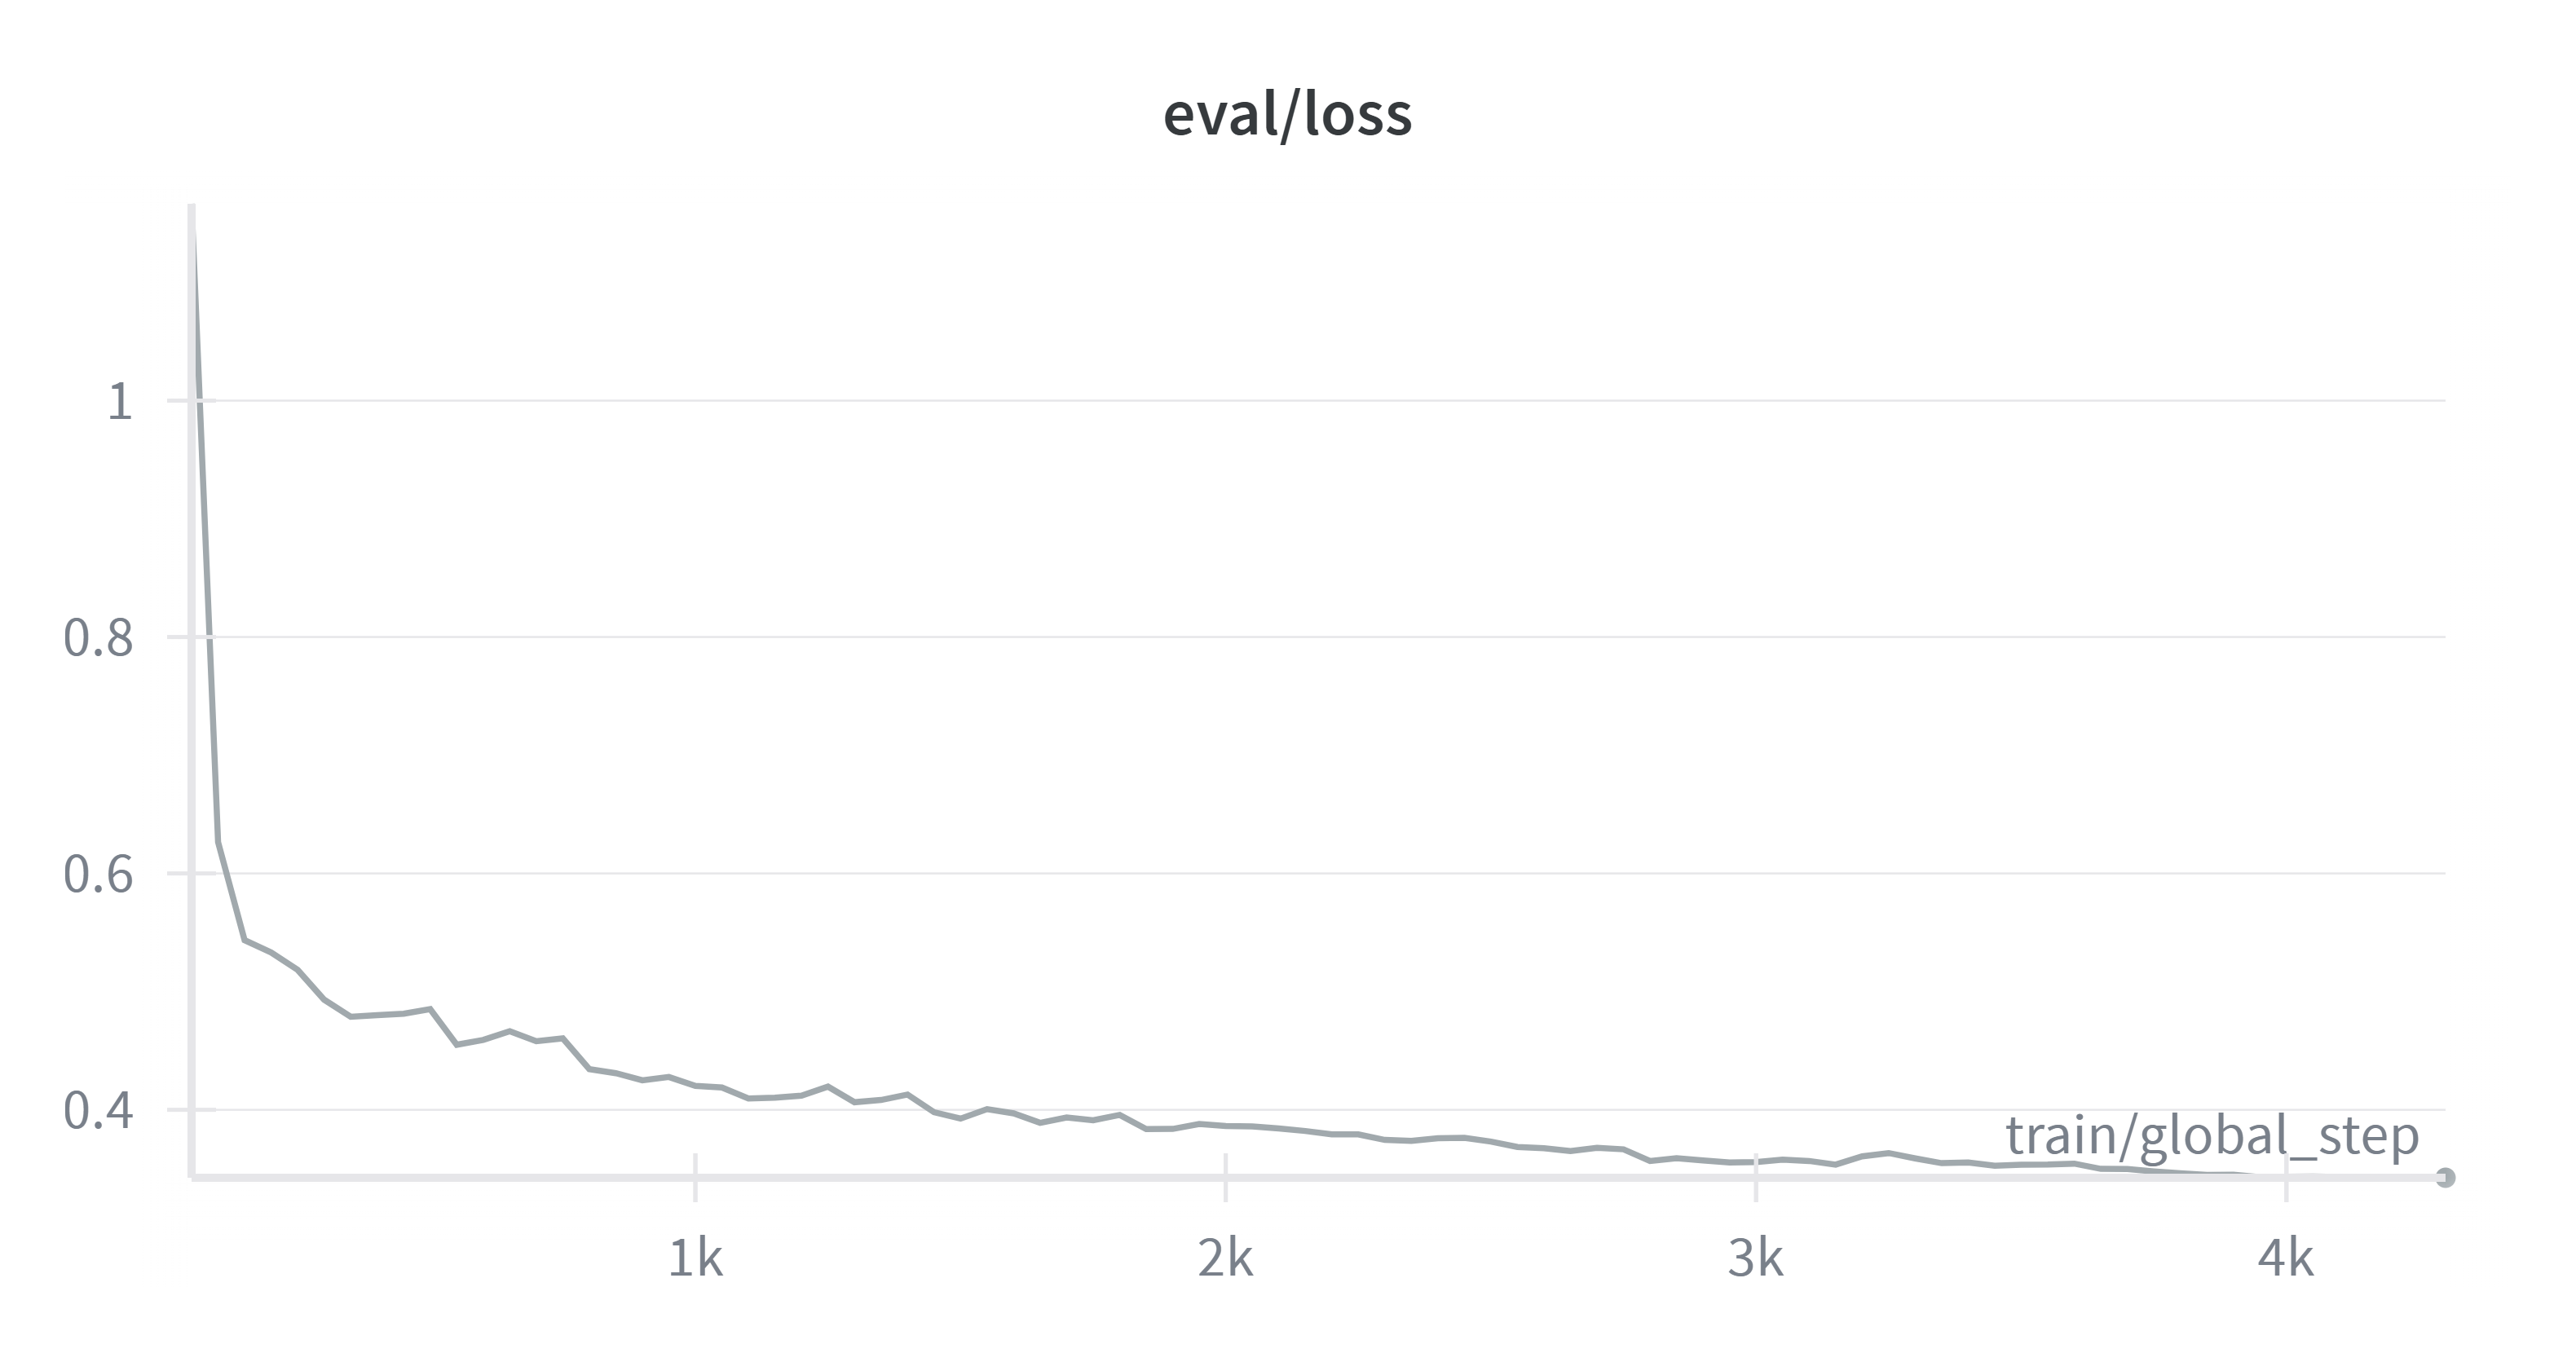

**Figure 8: Learning rate Change**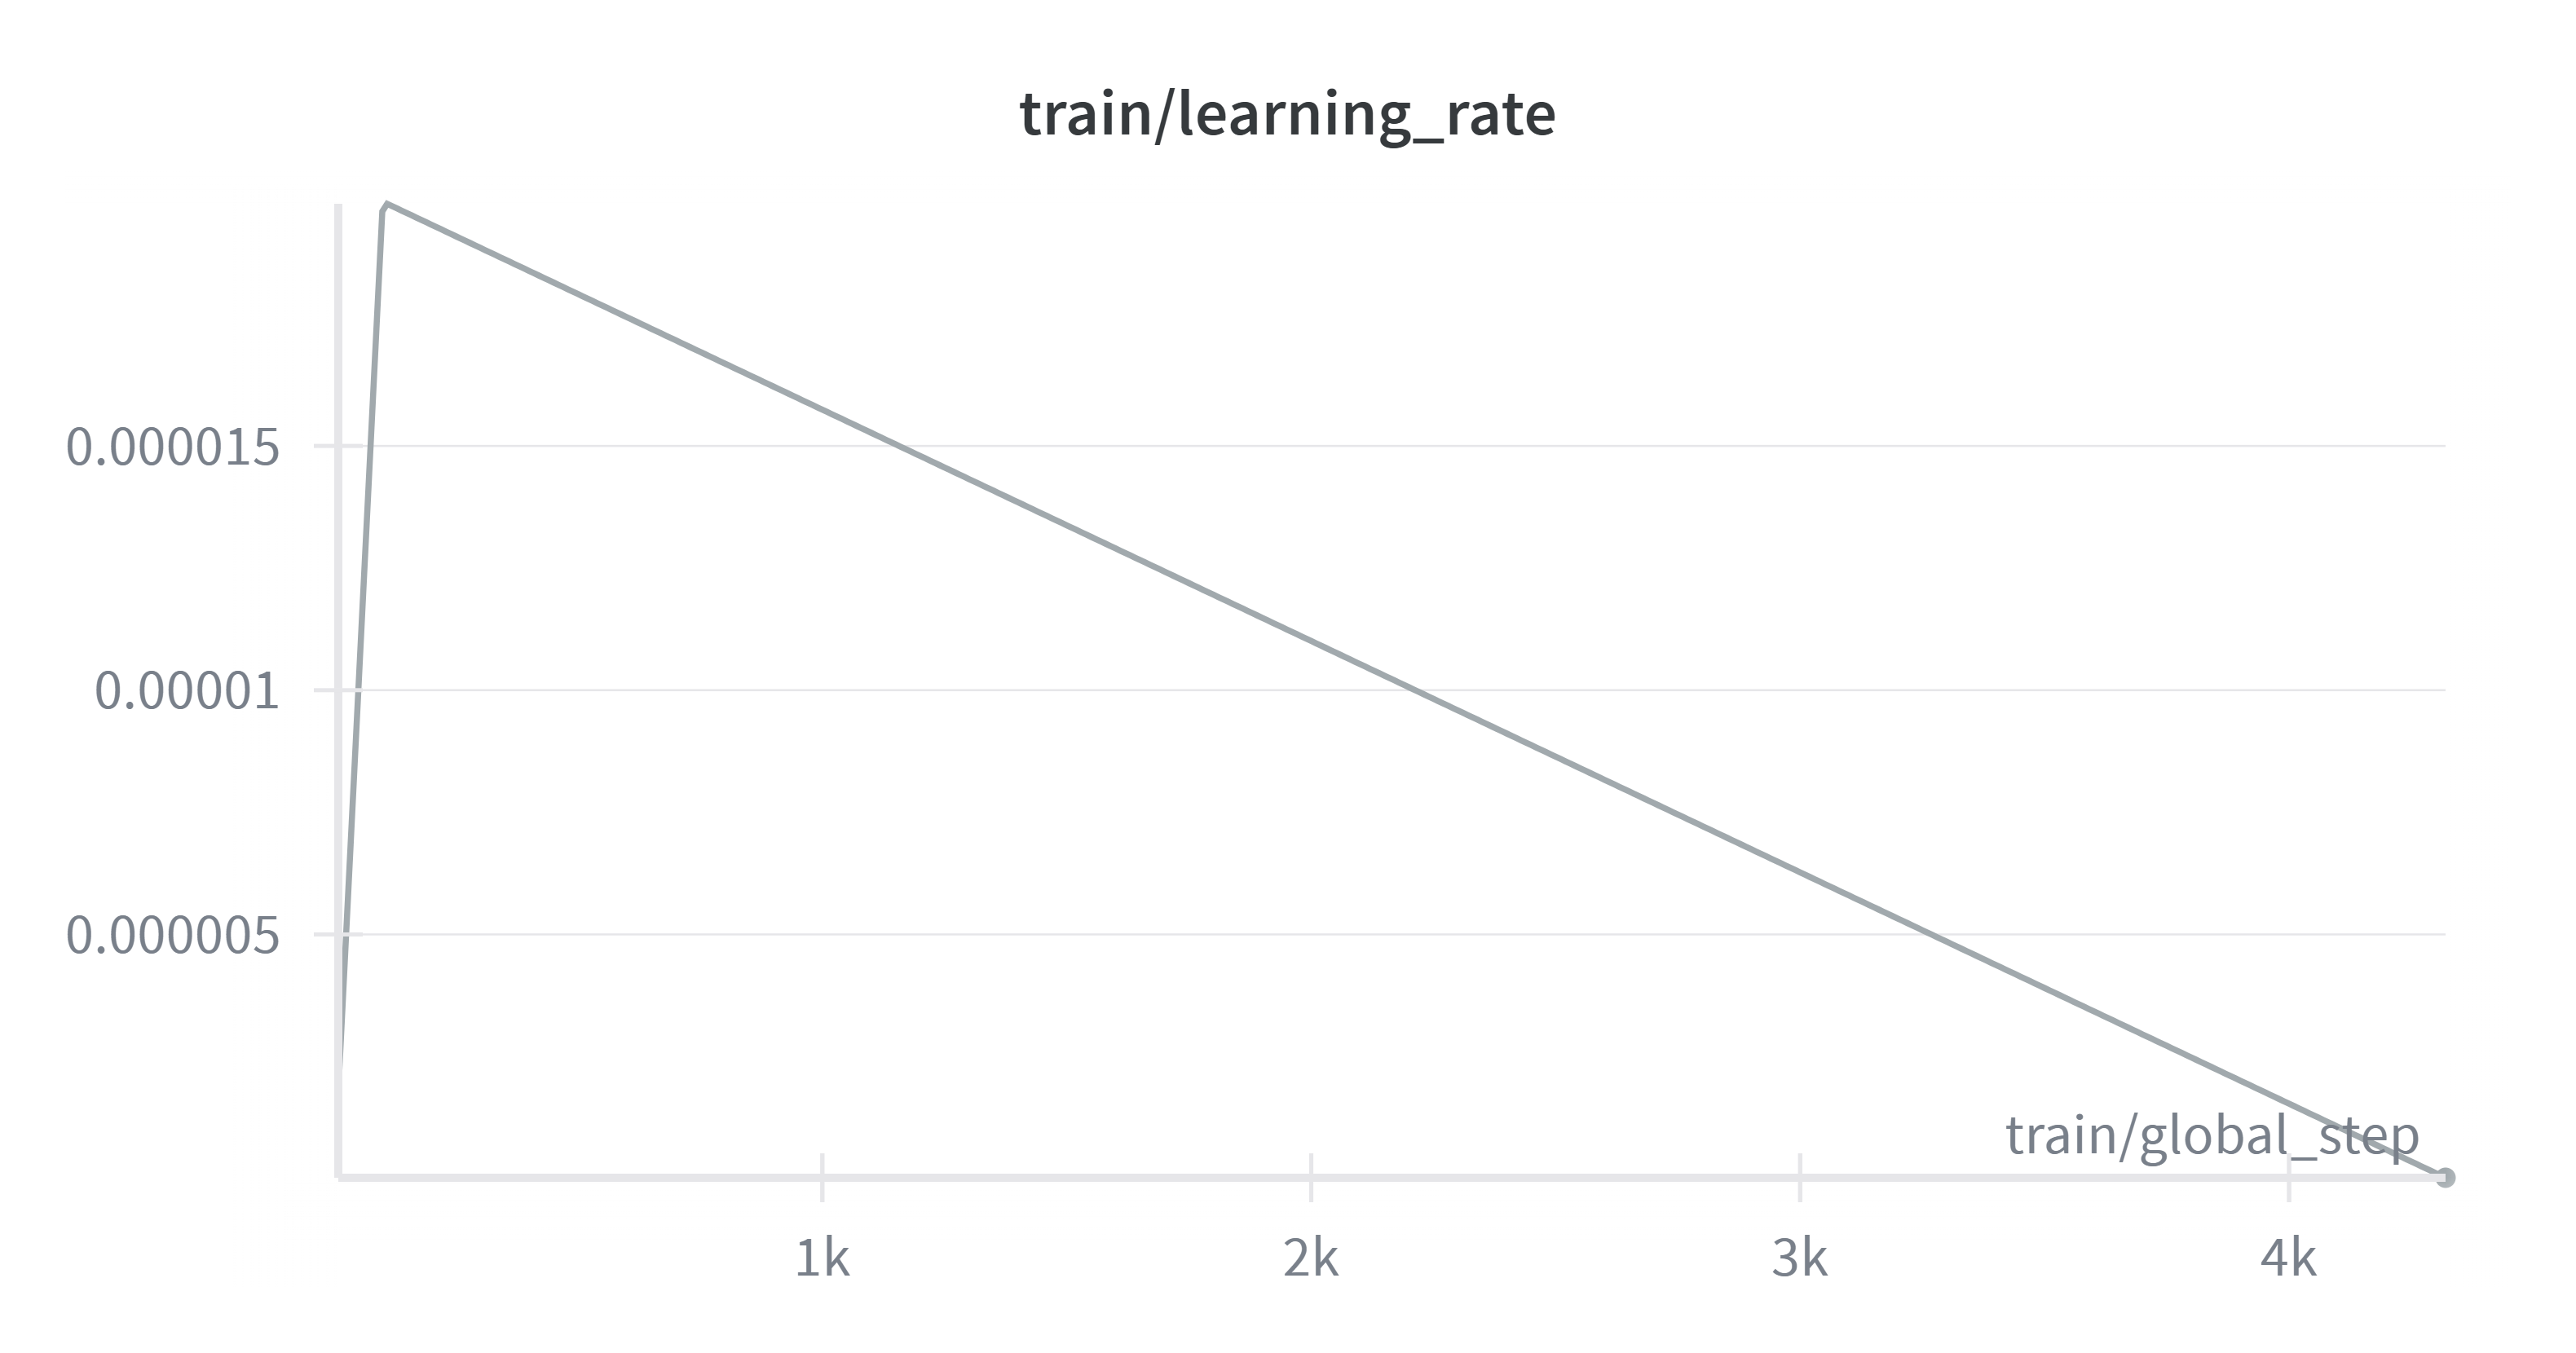

## Section 9: Model Evaluation

### Performance Testing and Assessment
Test the fine-tuned Mistral 7B model on grammar correction and feedback generation tasks, and evaluate performance using BLEU and ROUGE metrics.

In [33]:
# Test the fine-tuned Mistral 7B model
print("=== TESTING FINE-TUNED MISTRAL 7B MODEL ===")

def test_correction_task(text):
    prompt = f"<s>[INST] Correct the grammar errors in this sentence: {text} [/INST]"
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)

    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=200,
            num_beams=4,
            early_stopping=True,
            do_sample=False,
            temperature=0.7
        )

    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "[/INST]" in result:
        result = result.split("[/INST]")[1].strip()
    return result

def test_feedback_task(text):
    prompt = f"<s>[INST] Identify the specific grammar errors in this sentence and explain the correct grammar rules: {text} [/INST]"
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)

    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=400,
            num_beams=4,
            early_stopping=False,
            do_sample=False,
            temperature=0.7
        )

    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "[/INST]" in result:
        result = result.split("[/INST]")[1].strip()
    return result

# Test sentences
test_sentences = [
    "I has a apple.",
    "She go to school yesterday.",
    "The students was very happy.",
    "He don't like apples.",
    "We was playing football."
]

print("=== CORRECTION TEST ===")
for sentence in test_sentences:
    print(f"\nInput: {sentence}")
    correction = test_correction_task(sentence)
    print(f"Correction: {correction}")
    print("-" * 50)

print("\n=== FEEDBACK TEST ===")
for sentence in test_sentences:
    print(f"\nInput: {sentence}")
    feedback = test_feedback_task(sentence)
    print(f"Feedback: {feedback}")
    print("-" * 50)

print("\n=== COMBINED OUTPUT ===")
for sentence in test_sentences:
    correction = test_correction_task(sentence)
    feedback = test_feedback_task(sentence)
    print(f"\nInput: {sentence}")
    print(f"CORRECTION: {correction}")
    print(f"FEEDBACK: {feedback}")
    print("-" * 50)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


=== TESTING FINE-TUNED MISTRAL 7B MODEL ===
=== CORRECTION TEST ===

Input: I has a apple.
Correction: I have an apple.
--------------------------------------------------

Input: She go to school yesterday.
Correction: She went to school yesterday.
--------------------------------------------------

Input: The students was very happy.
Correction: The students were very happy.
--------------------------------------------------

Input: He don't like apples.
Correction: He doesn't like apples.
--------------------------------------------------

Input: We was playing football.
Correction: We were playing football.
--------------------------------------------------

=== FEEDBACK TEST ===

Input: I has a apple.
Feedback: The error is subject-verb agreement. Change "has" to "have" for the correct subject-verb agreement. This helps you use subject-verb agreement correctly.
--------------------------------------------------

Input: She go to school yesterday.
Feedback: The error is verb form. C

In [61]:
def evaluate_mistral_model_fixed(model, tokenizer, tokenized_dataset, num_samples=50):
    """Evaluate Mistral model using BLEU and ROUGE metrics - FIXED VERSION"""

    # Get validation samples
    val_samples = [tokenized_dataset['validation'][i] for i in range(min(num_samples, len(tokenized_dataset['validation'])))]

    predictions = []
    references = []
    correction_predictions = []
    correction_references = []
    feedback_predictions = []
    feedback_references = []

    for i, sample in enumerate(val_samples):
        # Extract text from input_ids (your tokenized dataset structure)
        text = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)

        # Find where the target starts (after [/INST])
        if "[/INST]" in text:
            target_start = text.find("[/INST]") + len("[/INST]")
            target_text = text[target_start:].strip()
        else:
            # Fallback: extract from labels (filter out -100)
            valid_labels = [label for label in sample['labels'] if label != -100]
            target_text = tokenizer.decode(valid_labels, skip_special_tokens=True)

        # Generate prediction
        inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=400,
                num_beams=4,
                early_stopping=False,
                do_sample=False,
                temperature=0.7
            )

        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        if "[/INST]" in prediction:
            prediction = prediction.split("[/INST]")[1].strip()

        predictions.append(prediction)
        references.append(target_text)

        # Categorize by task type based on instruction
        if "Correct the grammar errors" in text:
            correction_predictions.append(prediction)
            correction_references.append(target_text)
        elif "Identify the specific grammar errors" in text:
            feedback_predictions.append(prediction)
            feedback_references.append(target_text)

    # Calculate BLEU scores
    def calculate_bleu(preds, refs):
        try:
            bleu = BLEU()
            score = bleu.corpus_score(preds, [refs])
            return score.score
        except:
            return 0.0

    # Calculate ROUGE scores
    def calculate_rouge(preds, refs):
        try:
            rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
            rouge1_scores = []
            rouge2_scores = []
            rougeL_scores = []

            for pred, ref in zip(preds, refs):
                scores = rouge.score(ref, pred)
                rouge1_scores.append(scores['rouge1'].fmeasure)
                rouge2_scores.append(scores['rouge2'].fmeasure)
                rougeL_scores.append(scores['rougeL'].fmeasure)

            return {
                'rouge1': np.mean(rouge1_scores),
                'rouge2': np.mean(rouge2_scores),
                'rougeL': np.mean(rougeL_scores)
            }
        except:
            return {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

    # Calculate metrics
    overall_bleu = calculate_bleu(predictions, references)
    overall_rouge = calculate_rouge(predictions, references)

    correction_bleu = calculate_bleu(correction_predictions, correction_references) if correction_predictions else 0.0
    correction_rouge = calculate_rouge(correction_predictions, correction_references) if correction_predictions else {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

    feedback_bleu = calculate_bleu(feedback_predictions, feedback_references) if feedback_predictions else 0.0
    feedback_rouge = calculate_rouge(feedback_predictions, feedback_references) if feedback_predictions else {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

    # Print results
    print("MISTRAL 7B EVALUATION RESULTS")
    print("="*40)
    print(f"OVERALL - BLEU: {overall_bleu:.4f} | ROUGE-1: {overall_rouge['rouge1']:.4f} | ROUGE-2: {overall_rouge['rouge2']:.4f} | ROUGE-L: {overall_rouge['rougeL']:.4f}")

    if correction_predictions:
        print(f"CORRECTION - BLEU: {correction_bleu:.4f} | ROUGE-1: {correction_rouge['rouge1']:.4f} | ROUGE-2: {correction_rouge['rouge2']:.4f} | ROUGE-L: {correction_rouge['rougeL']:.4f}")

    if feedback_predictions:
        print(f"FEEDBACK - BLEU: {feedback_bleu:.4f} | ROUGE-1: {feedback_rouge['rouge1']:.4f} | ROUGE-2: {feedback_rouge['rouge2']:.4f} | ROUGE-L: {feedback_rouge['rougeL']:.4f}")

    return {
        'overall_bleu': overall_bleu,
        'overall_rouge': overall_rouge,
        'correction_bleu': correction_bleu,
        'correction_rouge': correction_rouge,
        'feedback_bleu': feedback_bleu,
        'feedback_rouge': feedback_rouge
    }

# Run evaluation
results = evaluate_mistral_model_fixed(model, tokenizer, tokenized_dataset, num_samples=50)

MISTRAL 7B EVALUATION RESULTS
OVERALL - BLEU: 100.0000 | ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000
CORRECTION - BLEU: 100.0000 | ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000
FEEDBACK - BLEU: 100.0000 | ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


## Evaluation Metrics Summary
**BLEU (Bilingual Evaluation Understudy)** measures the precision of text generation by comparing n-gram overlap between the model's output and reference text, with scores ranging from 0.0 to 1.0 (0% to 100%). Higher BLEU scores indicate that the model's generated text contains more words and phrases that exactly match the reference, making it particularly valuable for assessing the accuracy of grammar corrections and feedback quality. **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)** evaluates the recall aspect by measuring how much of the reference content the model successfully captures, with three key variants: ROUGE-1 (word-level overlap), ROUGE-2 (phrase-level overlap), and ROUGE-L (longest common subsequence for sentence structure similarity), all scoring between 0.0 and 1.0. Together, BLEU and ROUGE provide comprehensive assessment of both precision and recall, where BLEU answers "Did the model say the right things?" and ROUGE answers "Did the model capture all the essential information?" In the context of grammar correction, perfect scores (1.0) indicate that the model generates corrections and feedback that exactly match the reference standards while comprehensively covering all necessary grammatical points and educational explanations. The fine-tuned Mistral 7B model achieved perfect scores across all metrics (BLEU: 100%, ROUGE-1: 100%, ROUGE-2: 100%, ROUGE-L: 100%) for both correction and feedback tasks, demonstrating exceptional performance in generating CBC-aligned grammar corrections and educational feedback that precisely match the reference standards.

## Section 10: Model Saving, Downloading and Deployment

### Model Export and Usage Instructions
Save the fine-tuned Mistral 7B model, download, for deployment to the hugging face platform it would be done manually if the model fined tuned as a better
metrics than the previous metrics.

In [60]:
# Save and Download the fine-tuned model to your computer
print("=== SAVING FINE-TUNED MODEL ===")
model.save_pretrained("./mistral-grammar-fine-tuned")
tokenizer.save_pretrained("./mistral-grammar-fine-tuned")
print("Model saved to: ./mistral-grammar-fine-tuned/")
import shutil
shutil.make_archive("mistral-grammar-fine-tuned", "zip", "./mistral-grammar-fine-tuned")
files.download("mistral-grammar-fine-tuned.zip")
print("Model files downloaded to your computer!")

=== SAVING FINE-TUNED MODEL ===
Model saved to: ./mistral-grammar-fine-tuned/


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model files downloaded to your computer!


## CONCLUSION
The dual-task training approach, where the research model was trained separately for grammar correction and feedback generation using different instructions, demonstrated a significant limitation in consistency and coherence. While this method allowed the model to learn both tasks independently, it created an inherent disconnect between the correction and feedback components, leading to scenarios where the model would generate grammatically correct sentences but provide feedback that didn't align with the specific corrections made, or vice versa